# KCNI Summer School 2022 - PyTorch WBM Project

In [1]:
from google.colab import drive
drive.mount("/content/drive")
# @title Mount Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/github/kcnischool2022-projectweek/

/content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/github/kcnischool2022-projectweek


Approximate run duration: XX

## Setup

Importage

In [3]:
import os,sys,glob,numpy as np,pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import nibabel as nib

#import hcp_utils as hcp

Mount drive

In [4]:
!pwd

/content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/github/kcnischool2022-projectweek


## Get the data

In [5]:
from kspw.utils import load_stockholm_data
from kspw.pytorrww import Model_fitting,h_tf,RNNWWD,plot_fit_parameters,plot_sim_states_outputs,run_forward_model_newParas


In [10]:

stuff = load_stockholm_data()
schaf_idxs,schaf_labs,schaf_rgbs,schaf_dat,subs,dwiconn_dfs,ptsrs_dfs,pcrs_dfs = stuff
subsesses = list(pcrs_dfs.keys())

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [11]:
ss = subsesses[0]
mat = pcrs_dfs[ss].copy()
for ss in subsesses[1:]:
    mat+=pcrs_dfs[ss]
mat/=len(pcrs_dfs)
pcrs_mn = mat

s = subs[0]
mat = dwiconn_dfs[s].copy()
for s in subs[1:]:
    mat+=dwiconn_dfs[s]
mat/=len(dwiconn_dfs[s])
dwiconn_mn = mat


s = subs[0]
mat = dwiconn_dfs[s].apply(np.log1p).copy()
for s in subs[1:]:
    mat+=dwiconn_dfs[s].apply(np.log1p)
mat/=len(dwiconn_dfs[s])
dwiconn_log1p_mn = mat

In [12]:
subs

array([9002, 9003, 9004, 9005, 9008, 9009, 9011, 9014, 9018, 9020, 9023,
       9025, 9026, 9028, 9029, 9032, 9033, 9034, 9036, 9038, 9039, 9040,
       9041, 9042, 9045, 9046, 9047, 9048, 9049, 9055, 9058, 9061, 9062,
       9064, 9065, 9068, 9069, 9071, 9072, 9075, 9079, 9080, 9081, 9084,
       9085, 9086, 9087, 9088, 9089, 9092, 9093, 9094, 9096, 9098])

## Run Fitting

In [7]:
data_dir ='data/'

In [8]:
par_opt=np.loadtxt(data_dir +'para_optimal.txt')#[F.model.g.detach().numpy()[0], F.model.g_EE.detach().numpy()[0], F.model.g_IE.detach().numpy(), F.model.g_EI.detach().numpy(), \
         #F.model.std_in.detach().numpy(),F.model.std_out.detach().numpy()]
gain_opt = np.loadtxt(data_dir +'gain_optimal.txt')#F.model.w_bb.detach().numpy()

0.6350361954469184


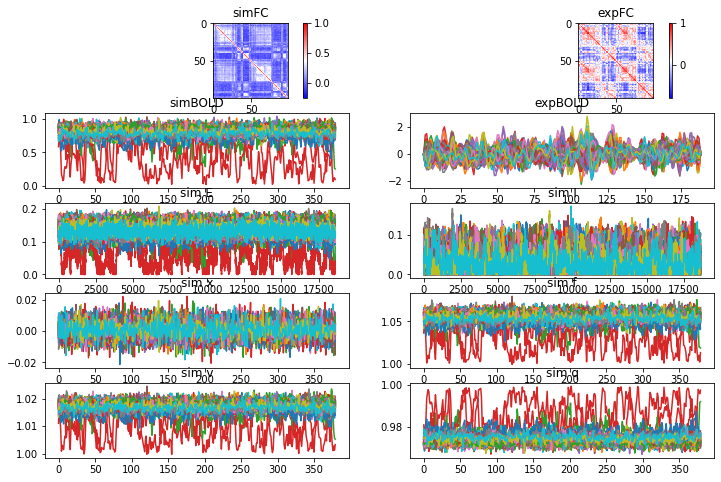

In [17]:
# Sub 1, Fit gains True, 80 epochs
sub = subs[1]
sc = dwiconn_dfs[sub].values.copy()
sc =0.5*(sc+sc.T)
sc = np.log1p(sc)/np.linalg.norm(np.log1p(sc))
ts = ptsrs_dfs[sub,2].values.copy()
fc_emp = np.corrcoef(ts.T)
model = RNNWWD(input_size=2, node_size=100, batch_size=19, step_size=0.05, tr=2.5, sc=sc, fit_gains=True,
               g_mean_ini=80, g_std_ini = .1, gEE_mean_ini=2.5, gEE_std_ini = .1)
F = Model_fitting(model, ts, num_epochs=40)
g_opt = par_opt[0]
g_EE_opt = par_opt[1]
g_IE_opt = par_opt[2]
g_EI_opt = par_opt[3]
std_in_opt = par_opt[4]
std_out_opt = par_opt[5]

output_test = run_forward_model_newParas(F, g= g_opt, g_EE=g_EE_opt, g_IE=g_IE_opt, g_EI=g_EI_opt, std_in= std_in_opt, std_out=std_out_opt, w_bb=gain_opt)

plot_sim_states_outputs(ts, output_test)